In [1]:
import numpy as np
import ray
import chocloton
import numpy as np
import matplotlib.pyplot as plt

try:
    ray.shutdown()
except:
    pass

ncores = 2
ray.init(num_cpus = ncores)

2023-12-18 07:09:15,737	INFO worker.py:1673 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.8.1


In [2]:
def is_psd(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

class randomCorrelation():
    
    def __init__(self, n_distr, n_dims):

        self.n_distr = n_distr
        self.dims = n_dims
        self.rM = [] 

    def generate_correlations(self):
        
        psd = 0
        same_sign = 0

        count=0
        for i in range(self.n_distr):


            half = np.random.uniform(-1,1,size=self.dims*(self.dims+1)//2 - self.dims)
            V = np.diag(np.ones(self.dims))               # Random psuedo correlation matrix
            indices = np.tril_indices(self.dims, k=-1)

            V[indices] = half 
            V.T[indices] = half 

            psd+=is_psd(V) # Positive semi-definite condition


            if ~is_psd(V):
                self.rM.append(V)
                count+=1
        print(self.dims, 'dimensions,', 'percent positive semi-definite', psd/self.n_distr)


for d in range(2,10):
    rc_0 = randomCorrelation(n_distr=20000, n_dims=d)
    rc_0.generate_correlations()

2 dimensions, percent positive semi-definite 1.0
3 dimensions, percent positive semi-definite 0.61685
4 dimensions, percent positive semi-definite 0.18475
5 dimensions, percent positive semi-definite 0.0216
6 dimensions, percent positive semi-definite 0.00075
7 dimensions, percent positive semi-definite 0.0
8 dimensions, percent positive semi-definite 0.0
9 dimensions, percent positive semi-definite 0.0


In [3]:
import numpy as np
from numpy import diag, inf
from numpy import copy, dot
from numpy.linalg import norm
import pandas as pd

class ExceededMaxIterationsError(Exception):
    def __init__(self, msg, matrix=[], iteration=[], ds=[]):
        self.msg = msg
        self.matrix = matrix
        self.iteration = iteration
        self.ds = ds

    def __str__(self):
        return repr(self.msg)


def nearcorr(A, tol=[], flag=0, max_iterations=100, n_pos_eig=0,
             weights=None, verbose=False,
             except_on_too_many_iterations=True):
    """
    X = nearcorr(A, tol=[], flag=0, max_iterations=100, n_pos_eig=0,
        weights=None, print=0)
    Finds the nearest correlation matrix to the symmetric matrix A.
    ARGUMENTS
    ~~~~~~~~~
    A is a symmetric numpy array or a ExceededMaxIterationsError object
    tol is a convergence tolerance, which defaults to 16*EPS.
    If using flag == 1, tol must be a size 2 tuple, with first component
    the convergence tolerance and second component a tolerance
    for defining "sufficiently positive" eigenvalues.
    flag = 0: solve using full eigendecomposition (EIG).
    flag = 1: treat as "highly non-positive definite A" and solve
    using partial eigendecomposition (EIGS). CURRENTLY NOT IMPLEMENTED
    max_iterations is the maximum number of iterations (default 100,
    but may need to be increased).
    n_pos_eig (optional) is the known number of positive eigenvalues
    of A. CURRENTLY NOT IMPLEMENTED
    weights is an optional vector defining a diagonal weight matrix diag(W).
    verbose = True for display of intermediate output.
    CURRENTLY NOT IMPLEMENTED
    except_on_too_many_iterations = True to raise an exeption when
    number of iterations exceeds max_iterations
    except_on_too_many_iterations = False to silently return the best result
    found after max_iterations number of iterations
    ABOUT
    ~~~~~~
    This is a Python port by Michael Croucher, November 2014
    Thanks to Vedran Sego for many useful comments and suggestions.
    Original MATLAB code by N. J. Higham, 13/6/01, updated 30/1/13.
    Reference:  N. J. Higham, Computing the nearest correlation
    matrix---A problem from finance. IMA J. Numer. Anal.,
    22(3):329-343, 2002.
    """

    # If input is an ExceededMaxIterationsError object this
    # is a restart computation
    if (isinstance(A, ExceededMaxIterationsError)):
        ds = copy(A.ds)
        A = copy(A.matrix)
    else:
        ds = np.zeros(np.shape(A))

    eps = np.spacing(1)
    if not np.all((np.transpose(A) == A)):
        raise ValueError('Input Matrix is not symmetric')
    if not tol:
        tol = eps * np.shape(A)[0] * np.array([1, 1])
    if weights is None:
        weights = np.ones(np.shape(A)[0])
    X = copy(A)
    Y = copy(A)
    rel_diffY = inf
    rel_diffX = inf
    rel_diffXY = inf

    Whalf = np.sqrt(np.outer(weights, weights))

    iteration = 0
    while max(rel_diffX, rel_diffY, rel_diffXY) > tol[0]:
        iteration += 1
        if iteration > max_iterations:
            if except_on_too_many_iterations:
                if max_iterations == 1:
                    message = "No solution found in "\
                              + str(max_iterations) + " iteration"
                else:
                    message = "No solution found in "\
                              + str(max_iterations) + " iterations"
                raise ExceededMaxIterationsError(message, X, iteration, ds)
            else:
                # exceptOnTooManyIterations is false so just silently
                # return the result even though it has not converged
                return X

        Xold = copy(X)
        R = X - ds
        R_wtd = Whalf*R
        if flag == 0:
            X = proj_spd(R_wtd)
        elif flag == 1:
            raise NotImplementedError("Setting 'flag' to 1 is currently\
                                 not implemented.")
        X = X / Whalf
        ds = X - R
        Yold = copy(Y)
        Y = copy(X)
        np.fill_diagonal(Y, 1)
        normY = norm(Y, 'fro')
        rel_diffX = norm(X - Xold, 'fro') / norm(X, 'fro')
        rel_diffY = norm(Y - Yold, 'fro') / normY
        rel_diffXY = norm(Y - X, 'fro') / normY

        X = copy(Y)

    return X


def proj_spd(A):
    # NOTE: the input matrix is assumed to be symmetric
    d, v = np.linalg.eigh(A)
    A = (v * np.maximum(d, 0)).dot(v.T)
    A = (A + A.T) / 2
    return(A)


def get_eig_vals(X):
    return np.linalg.eigvals(X)

import seaborn as sns

def compare_corr_heatmaps(a, b, c, annot = True):

    plt.figure(figsize=(20, 9))
    ax1 = plt.subplot(131)
    sns.heatmap(a, annot = annot)
    ax2 = plt.subplot(132)
    sns.heatmap(b, annot = annot)
    ax3 = plt.subplot(133)
    sns.heatmap(b, annot = annot)
    
    ax1.title.set_text('Original Correlation Matrix')
    ax2.title.set_text('NearCorr Transformed Correlation Matrix')
    ax3.title.set_text('Choclo Transformed Correlation Matrix')
    
    plt.show()
    
    indices = np.tril_indices(a.shape[1],k=-1)
    
    plt.figure(figsize=(15, 9))
    ax = plt.subplot(121)
    corr = np.corrcoef(np.concatenate([a[indices].flatten()[:, np.newaxis], b[indices].flatten()[:, np.newaxis], c[indices].flatten()[:, np.newaxis]], axis=1).T)
    print(np.concatenate([a.flatten()[:, np.newaxis], b.flatten()[:, np.newaxis], c.flatten()[:, np.newaxis]], axis=1))
    df = pd.DataFrame(corr)
    df.columns = ['original', 'nearcorr', 'choclo']
    df.index = ['original', 'nearcorr', 'choclo']    
    sns.heatmap(df, annot = True)
    plt.title('Correlation')

    
    data = np.concatenate([a[indices].flatten()[:, np.newaxis], b[indices].flatten()[:, np.newaxis], c[indices].flatten()[:, np.newaxis]], axis=1)
    mse = np.ones((3,3))
    indices = np.tril_indices(mse.shape[1],k=-1)
    for i in range(3):
        for j in range(3):
            if i>j:
                mse[i, j] = np.mean(np.abs(data[:, i]-data[:, j]))
                mse[j, i] = mse[i, j]
                

    ax = plt.subplot(122)
    df = pd.DataFrame(mse)
    df.columns = ['original', 'nearcorr', 'choclo']
    df.index = ['original', 'nearcorr', 'choclo']    
    sns.heatmap(df, annot = True)
    plt.title('MAE')
    plt.show()        

rc_5 = randomCorrelation(n_distr=10000, n_dims=5)
rc_5.generate_correlations()


rc_50 = randomCorrelation(n_distr=10000, n_dims=50)
rc_50.generate_correlations()


5 dimensions, percent positive semi-definite 0.0224
50 dimensions, percent positive semi-definite 0.0


In [4]:
# indices

In [5]:
# for x in zip(indices[0], indices[0]):
#     print(x)

In [6]:
A = np.ones((50,50))

indices = np.tril_indices(A.shape[1],k=-1)

for v in np.linspace(-1/(A.shape[1]-1), 0.99, 10):
    A[indices] = v
    A.T[indices] = v
    print(is_psd(A))

True
True
True
True
True
True
True
True
True
True


In [7]:
A = np.ones((50,50))

indices = np.tril_indices(A.shape[1],k=-1)

for _ in range(100):
    r = np.random.uniform(-1/(A.shape[1]-1),1/(A.shape[1]-1), size=len(indices[0]))
    A[indices] = r
    A.T[indices] = r
    print(is_psd(A))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True



# NearCorr

In [8]:
V = rc_50.rM[0]

nearcorr_newV = nearcorr(V, max_iterations=1e10)

is_psd(nearcorr_newV)

False

In [9]:
indices = np.tril_indices(V.shape[1],k=-1)

In [10]:
np.linalg.eigvals(nearcorr_newV)

array([ 5.93380136e+00+0.00000000e+00j,  5.28389914e+00+0.00000000e+00j,
        4.60445292e+00+0.00000000e+00j,  4.22245522e+00+0.00000000e+00j,
        3.85553042e+00+0.00000000e+00j,  3.64295917e+00+0.00000000e+00j,
        3.38381968e+00+0.00000000e+00j,  3.21273203e+00+0.00000000e+00j,
        2.90629254e+00+0.00000000e+00j,  2.52507617e+00+0.00000000e+00j,
        2.36174259e+00+0.00000000e+00j,  1.98574415e+00+0.00000000e+00j,
        1.76855135e+00+0.00000000e+00j,  1.14375130e-01+0.00000000e+00j,
        1.24249626e+00+0.00000000e+00j,  1.05837915e+00+0.00000000e+00j,
        8.41179731e-01+0.00000000e+00j,  5.63661978e-01+0.00000000e+00j,
        4.92851017e-01+0.00000000e+00j, -9.46716642e-14+0.00000000e+00j,
       -1.02884017e-14+0.00000000e+00j, -6.47258646e-15+0.00000000e+00j,
       -4.75765976e-15+0.00000000e+00j, -3.70629292e-15+0.00000000e+00j,
        4.10114613e-15+0.00000000e+00j, -2.84027639e-15+0.00000000e+00j,
       -2.70716773e-15+0.00000000e+00j,  3.15232546

In [11]:

def loss_fcn(X,y,w,args):
    
    dim = X.shape[1]
    newV = X.copy()
    indices = np.tril_indices(dim,k=-1)

    newV[indices] = w.flatten()
    newV.T[indices] = w.flatten()
        
    # The error is the exponential of the average between negative eigenvalues
    # Another component at a lower importance level compares the similarity between 
    # the original and transformed correlation matrices 
    eigenvals = np.linalg.eigvals(newV)
    negative_eigenvals = np.abs(np.clip(eigenvals, -np.inf, 0))
    err = np.mean(negative_eigenvals)
    loss = np.exp(err+3) + np.mean(np.abs(X-newV)) - np.mean(X*newV)

    return loss

@ray.remote
def map_losses(X,y,w_list,w_indx,args):
    N = w_indx.shape[0]
    resX = np.zeros(N)
    iter_ = 0
    for i in w_indx:
        loss = loss_fcn(X, y, w_list[:,i:i+1], args)
        resX[iter_] = loss
        iter_+=1
    return resX
    

def ray_parallel_mapper(X,y,w_list,args):
    
    num_cores = 8
    
    weights_index = np.arange(0,w_list.shape[1])
    weights_index_split = np.array_split(weights_index,num_cores)
    
    w_list_id = ray.put(w_list)
    
    result_ids = [map_losses.remote(X_id,y_id,w_list_id,weights_index_split[i],args_id) for i in range(num_cores)]
    result = ray.get(result_ids)
    
    loss = []
    indx = []
    for l in result:
        loss.extend(l)
    loss = np.hstack(loss)
    return loss

def clip_parameter_transform(w,*args):
    # w[rows,columns] = (parameter set,iteration)
    return np.clip(w, 0.0, 1.0)

In [ ]:
V = rc_50.rM[0]
input_num = V.shape[1]*(V.shape[1]+1)//2 - V.shape[1]

zscore=2.0
realizations = 200
cycles = 20
volume = V.shape[1]
simulations = 400
volatility = 0.1


def clip_parameter_transform(w,*args):
    # w[rows,columns] = (parameter set,iteration)
    return np.clip(w, -1.0, 1.0)

X = V
y = 0

args=np.array([])

X_id = ray.put(V)
y_id = ray.put(y)
args_id = ray.put(args)

kml0 = chocloton.ChocloOptimizer(ray_parallel_mapper,
                 prior_sampler_fcn=None,
                 posterior_sampler_fcn=None,
                 intermediate_sampler_fcn=None,
                 parameter_transform_fcn=clip_parameter_transform,
                 batch_size=None)

kml0.optimize(X,y,
                                number_of_parameters=input_num,
                                args=[args],
                                number_of_realizations=realizations,
                                number_of_random_simulations =simulations,
                                update_volatility = volatility,
                                number_of_cycles=cycles,
                                update_volume=volume,
                                convergence_z_score=zscore,
                                prior_uniform_low=-1/(V.shape[1]-1),
                                prior_uniform_high=1/(V.shape[1]-1),
                                print_feedback=True)

kmldata0 = kml0.kmldata

In [13]:
kmldata0 = kml0.choclo_data

In [19]:
def is_psd(A):
    if np.array_equal(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

w = kmldata0.best_weight_vector
print(w)

V = rc_50.rM[0]
input_num = V.shape[1]*(V.shape[1]+1)//2 - V.shape[1]


newV = V.copy()

indices = np.tril_indices(V.shape[1],k=-1)

newV[indices] = w.flatten()
newV.T[indices] = w.flatten()

choclo_newV = np.clip(newV, -1.0, 1.0)

[[ 0.04327512  0.00872963  0.0484758  ... -0.02673417 -0.06892456
  -0.08083288]]


In [20]:
is_psd(choclo_newV)

False

In [21]:
np.linalg.eigvals(choclo_newV)

array([ 3.23470839e+00,  3.01798462e+00,  2.72382123e+00,  2.64868748e+00,
        2.45560420e+00,  2.31415749e+00,  2.28648588e+00,  2.23833007e+00,
        2.15054511e+00,  1.99823853e+00,  1.89972108e+00,  1.87011357e+00,
        1.68953527e+00,  1.54236377e+00,  1.53458646e+00,  1.50992775e+00,
        1.37294653e+00,  1.32221858e+00,  1.22405789e+00,  1.18494379e+00,
        1.11312705e+00,  1.08062219e+00,  1.03733151e+00,  9.16923454e-01,
        8.34787330e-01,  7.72474523e-01,  7.00970273e-01,  5.75370718e-01,
        4.99380706e-01,  4.80063335e-01,  3.88371818e-01,  3.05186873e-01,
        2.52399722e-01,  2.18947778e-01,  1.83941235e-01,  1.55465267e-01,
        6.20527924e-02,  5.54779864e-02,  3.92151724e-02,  2.68797809e-02,
        2.06978604e-02,  1.64697848e-02, -3.47388631e-05,  2.78276472e-04,
        1.13172814e-03,  1.35004053e-02,  4.46395070e-03,  7.52978465e-03,
        9.50953140e-03,  8.48619090e-03])

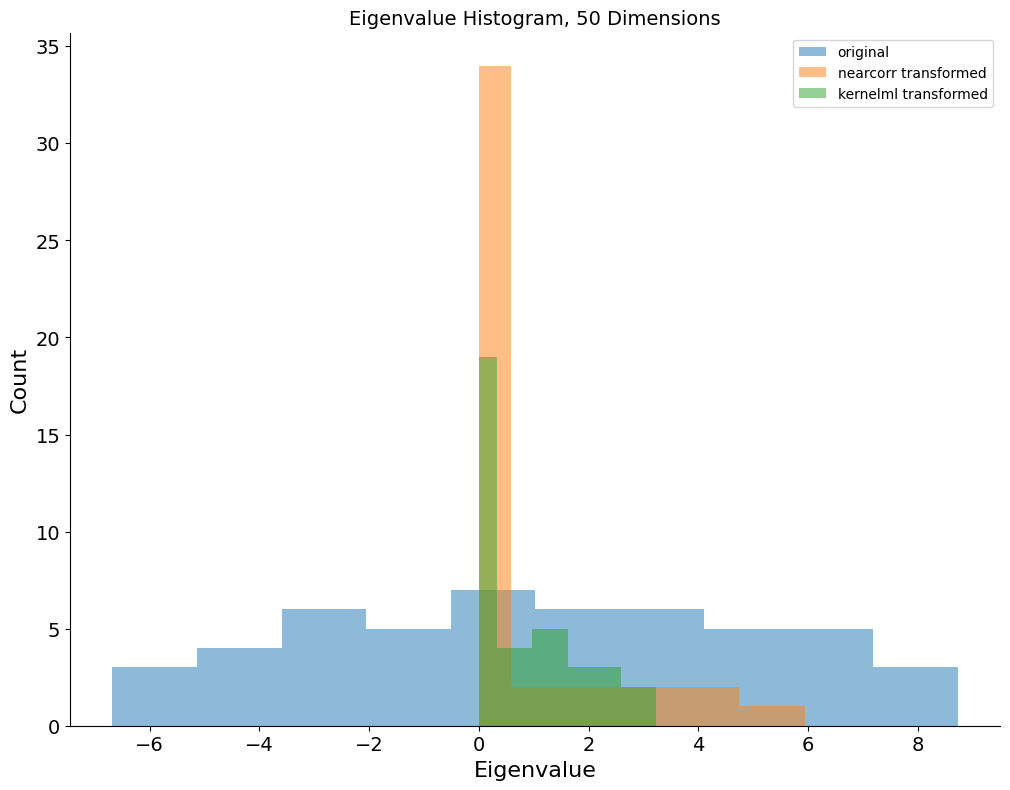

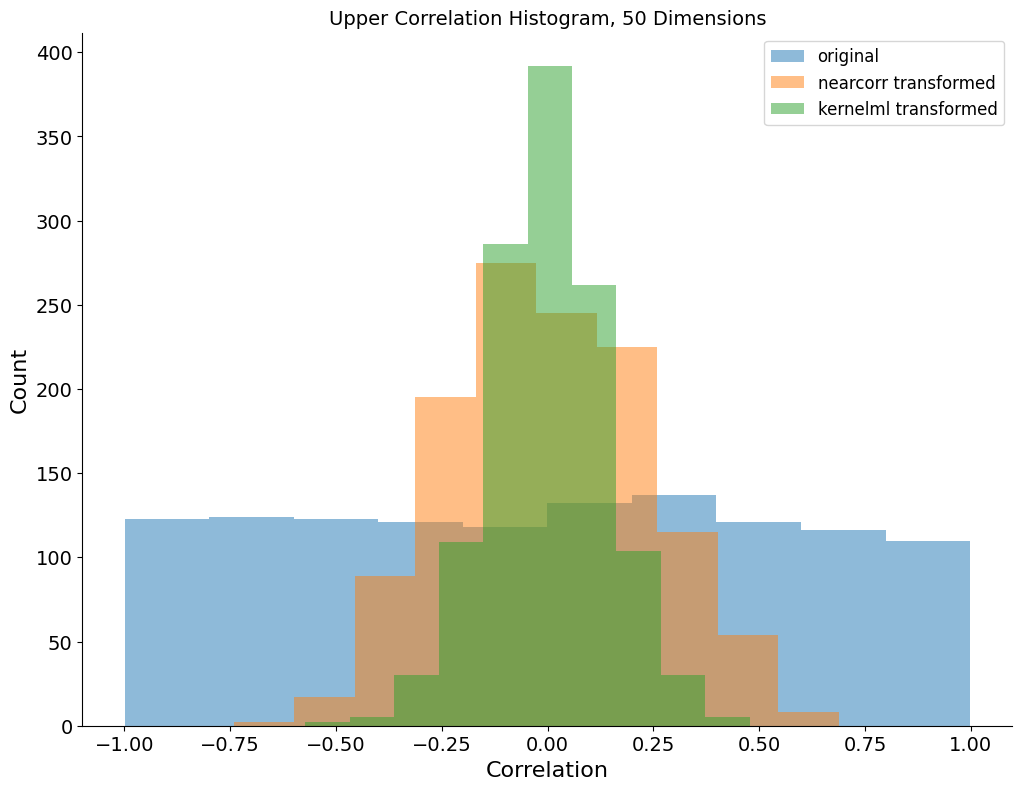

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(np.linalg.eigvals(V), alpha=0.5, label='original')
plt.hist(np.linalg.eigvals(nearcorr_newV), alpha=0.5, label='nearcorr transformed')
plt.hist(np.linalg.eigvals(choclo_newV), alpha=0.5, label='choclo transformed')
plt.title(f"Eigenvalue Histogram, 50 Dimensions", fontsize=14)
plt.xlabel("Eigenvalue", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend()
plt.show()

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(V[indices].flatten(), alpha=0.5, label='original')
plt.hist(nearcorr_newV[indices].flatten(), alpha=0.5, label='nearcorr transformed')
plt.hist(choclo_newV[indices].flatten(), alpha=0.5, label='choclo transformed')
plt.title(f"Upper Correlation Histogram, 50 Dimensions", fontsize=14)
plt.xlabel("Correlation", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.legend( prop={'size': 12})
plt.show()

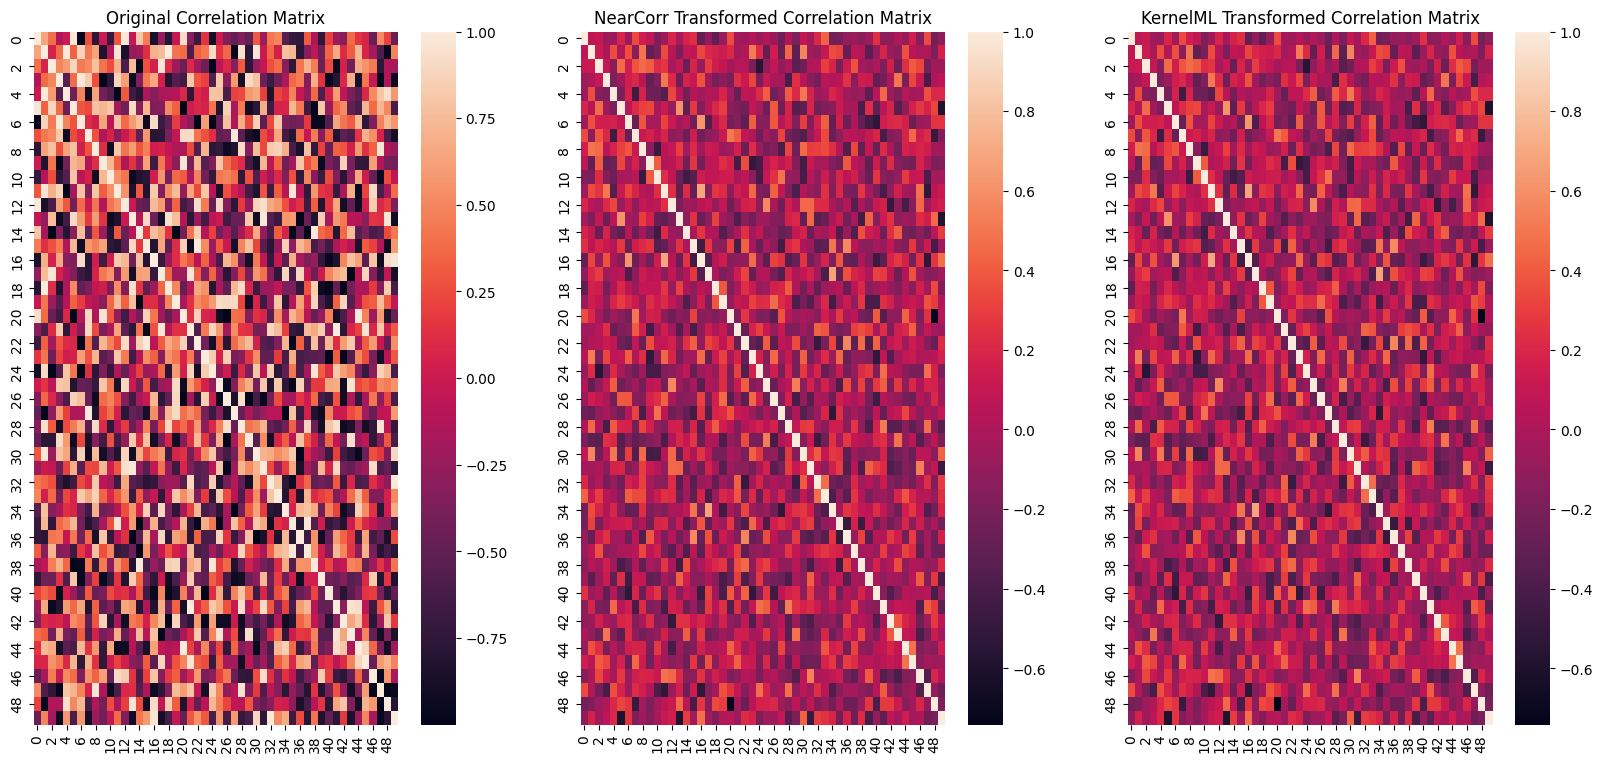

[[ 1.          1.          1.        ]
 [ 0.63587985  0.07618488  0.04327512]
 [ 0.39476812  0.11057887  0.00872963]
 ...
 [-0.95741621 -0.25336246 -0.06892456]
 [-0.78360899 -0.1900019  -0.08083288]
 [ 1.          1.          1.        ]]


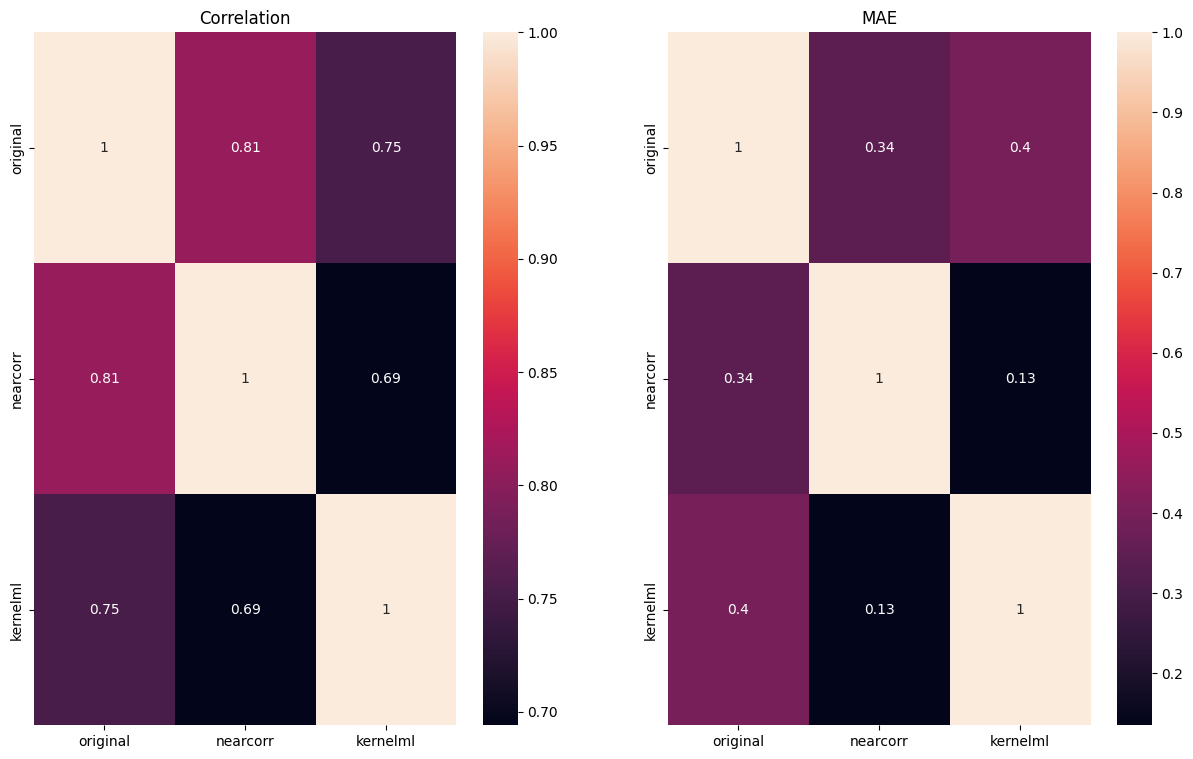

In [23]:
compare_corr_heatmaps(V, nearcorr_newV, choclo_newV, annot=False)

In [24]:
max_5_var = np.argsort(np.var(kmldata0.update_by_realization,axis=0))[-5:]

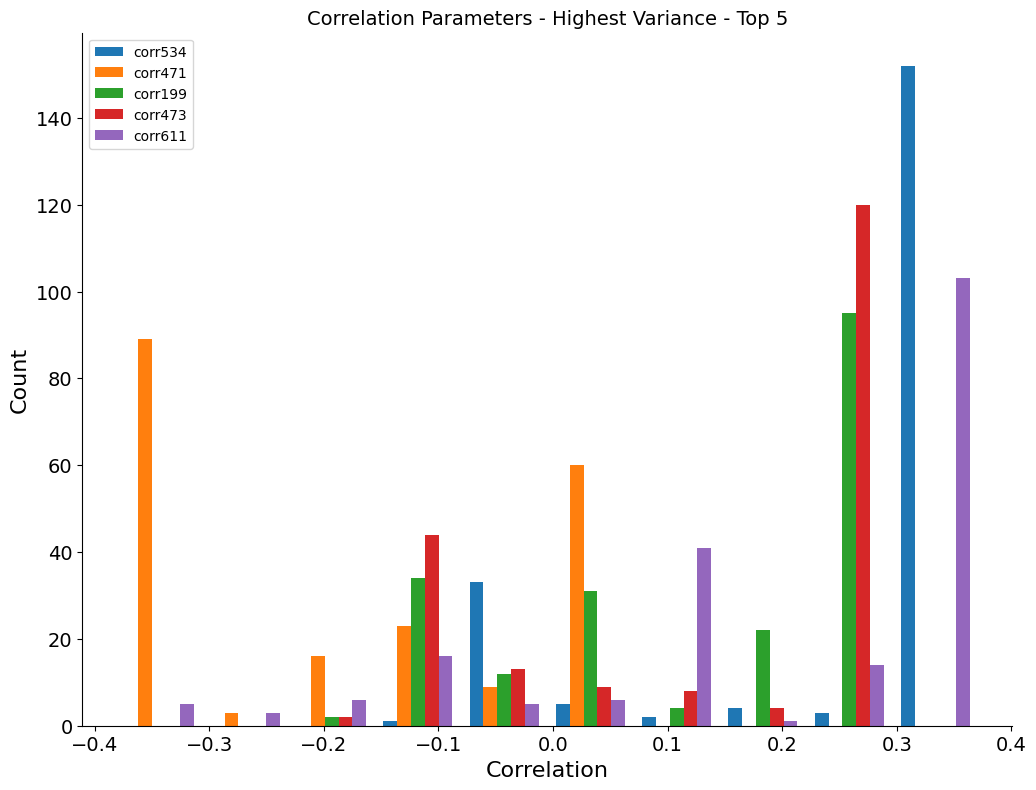

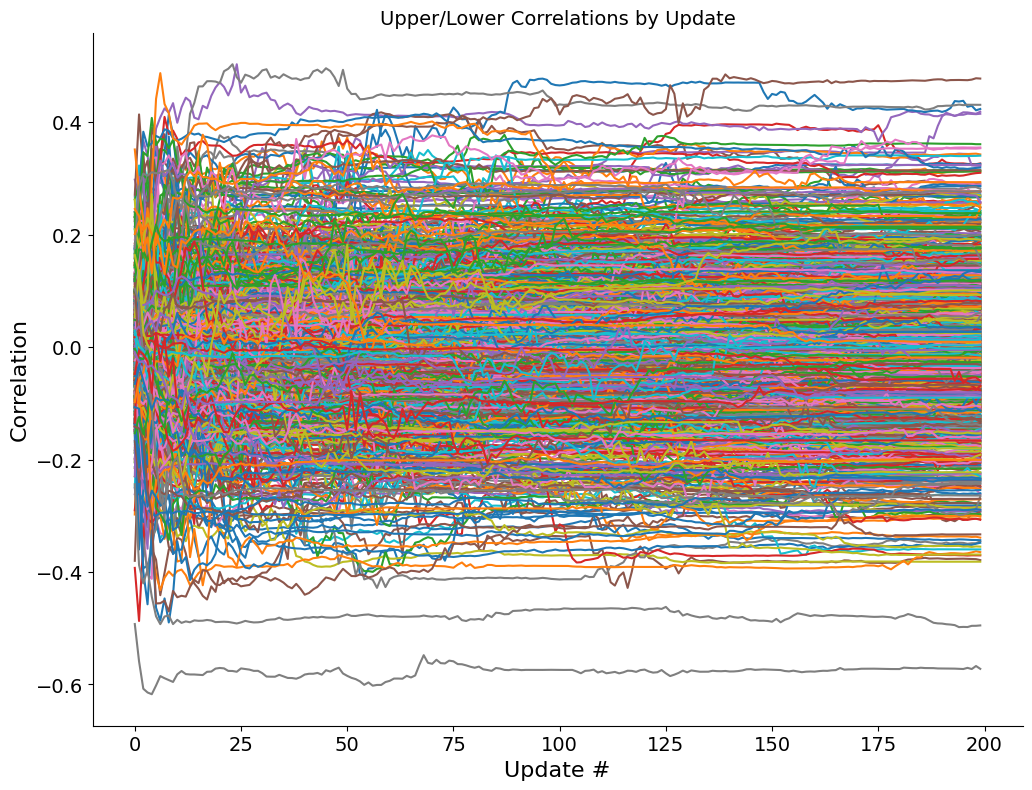

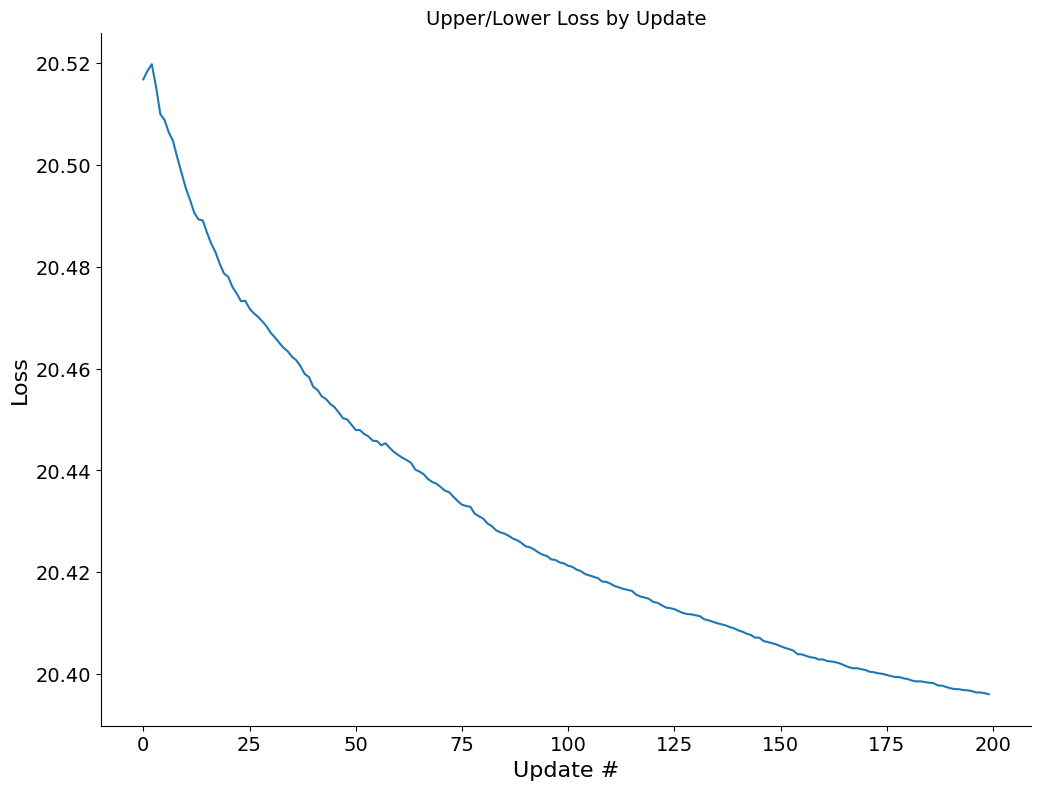

In [25]:
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

tmp = pd.DataFrame(kmldata0.update_by_realization[:, max_5_var])
tmp.columns = [f'corr{indx}' for indx in max_5_var]
plt.hist(tmp, label=[f'corr{indx}' for indx in max_5_var])
# tmp.hist()
plt.xlabel("Correlation", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Correlation Parameters - Highest Variance - Top 5", fontsize=14)
plt.legend()
plt.show()


plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(kmldata0.update_by_realization[:])
plt.xlabel("Update #", fontsize=16)
plt.ylabel("Correlation", fontsize=16)
plt.title("Upper/Lower Correlations by Update", fontsize=14)
plt.show()

plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(kmldata0.loss_by_realization[:])
plt.xlabel("Update #", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.title("Upper/Lower Loss by Update", fontsize=14)
plt.show()

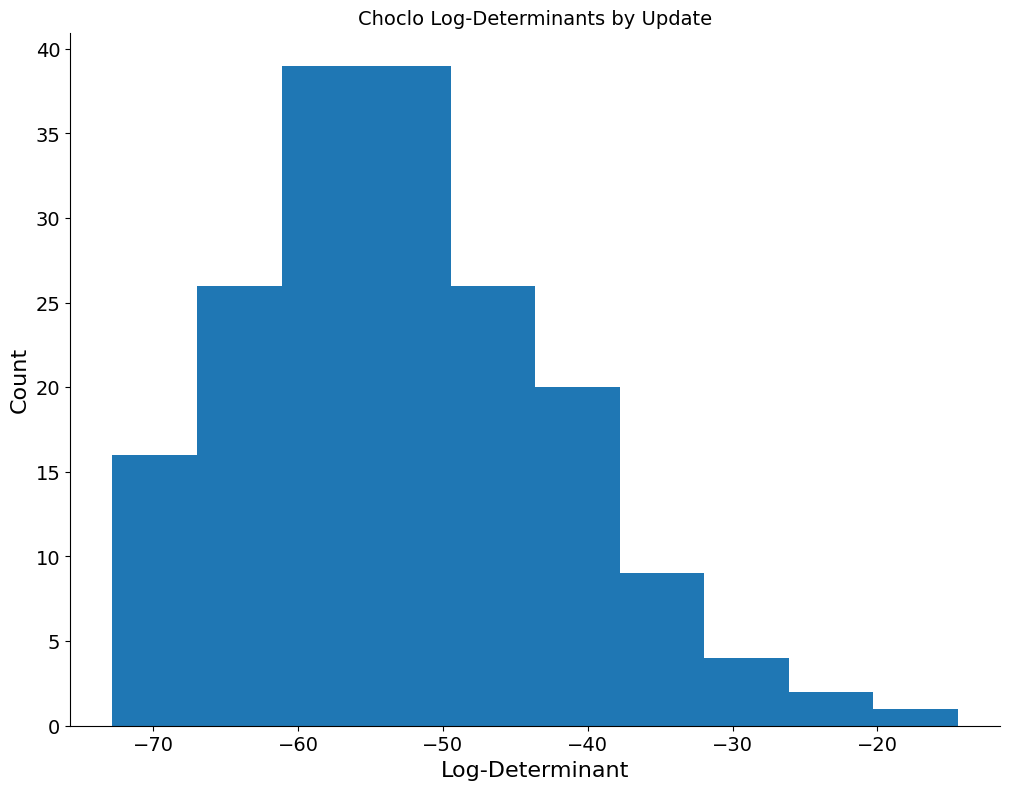

In [28]:
updatedVList = []
for w in kmldata0.update_by_realization:
    newV = V.copy()

    indices = np.tril_indices(V.shape[1],k=-1)

    newV[indices] = w.flatten()
    newV.T[indices] = w.flatten()
    
    if is_psd(newV):
        updatedVList.append(newV)
    
logDeterminants = []
for v in updatedVList:
    logDeterminants.append(np.log(np.linalg.det(v)))
    
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.hist(logDeterminants)
plt.xlabel("Log-Determinant", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.title("Choclo Log-Determinants by Update", fontsize=14)
plt.show()


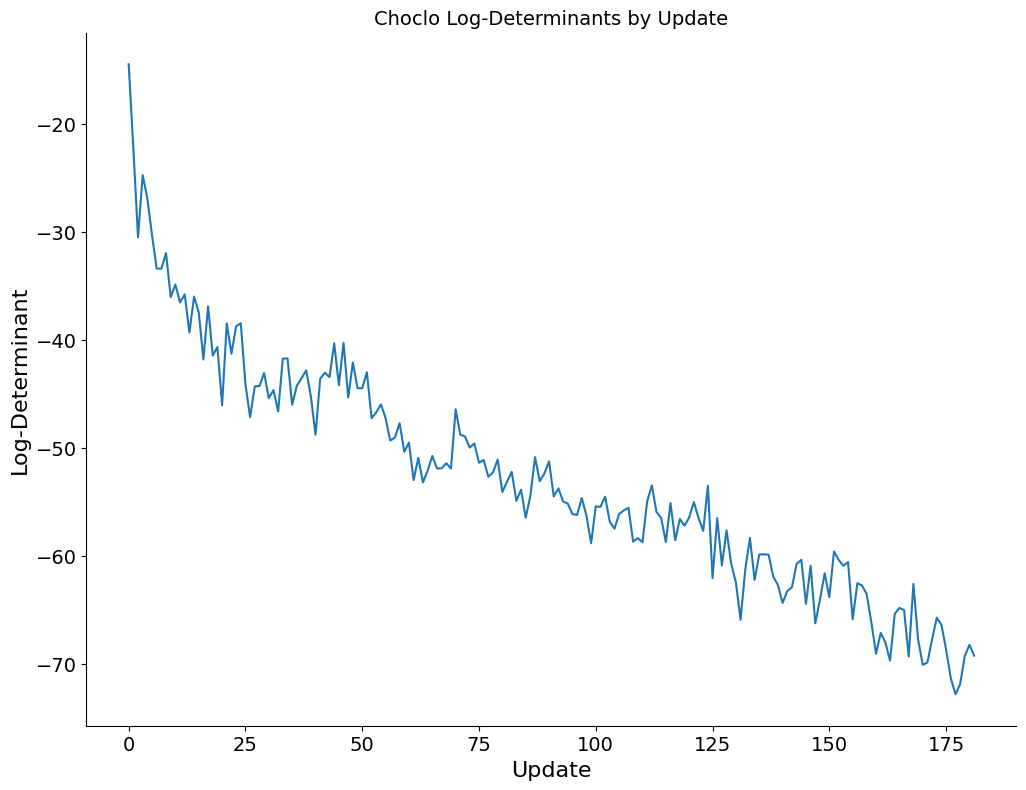

In [29]:
updatedVList = []
for w in kmldata0.update_by_realization:
    newV = V.copy()

    indices = np.tril_indices(V.shape[1],k=-1)

    newV[indices] = w.flatten()
    newV.T[indices] = w.flatten()
    
    if is_psd(newV):
        updatedVList.append(newV)
    
logDeterminants = []
for v in updatedVList:
    logDeterminants.append(np.log(np.linalg.det(v)))
    
plt.figure(figsize=(12, 9))
ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14) 

plt.plot(logDeterminants)
plt.xlabel("Update", fontsize=16)
plt.ylabel("Log-Determinant", fontsize=16)
plt.title("Choclo Log-Determinants by Update", fontsize=14)
plt.show()


In [30]:
eVa, eVe = np.linalg.eig(np.diag(np.ones(50)))
R, S = eVe, np.diag(np.sqrt(eVa))

In [31]:
eVa

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [32]:
eVa, eVe = np.linalg.eig(choclo_newV)
R, S = eVe, np.diag(np.sqrt(eVa))

C:\Users\rohan\AppData\Local\Temp\ipykernel_15244\2153690679.py:2: RuntimeWarning: invalid value encountered in sqrt
  R, S = eVe, np.diag(np.sqrt(eVa))


In [33]:
R[:,:3], S[:3]

(array([[-0.02661016, -0.02854284,  0.02816395],
        [ 0.06234861, -0.01713471,  0.17578611],
        [ 0.16424171,  0.05360041,  0.18443217],
        [ 0.10142785,  0.19078621,  0.04312722],
        [-0.14368532, -0.15508895,  0.06728615],
        [-0.02782566, -0.00789902,  0.18720503],
        [ 0.26432234, -0.0428596 ,  0.12170229],
        [ 0.11922877,  0.2056706 ,  0.12882984],
        [ 0.12315876, -0.21681623,  0.19370946],
        [ 0.03633542,  0.01131333, -0.01495299],
        [ 0.0255536 ,  0.14881924, -0.13345925],
        [ 0.1957027 ,  0.04352564, -0.28290572],
        [-0.00156723, -0.07889825, -0.0128509 ],
        [-0.04263628, -0.30728616, -0.02052803],
        [-0.18552808, -0.01914417, -0.17440956],
        [-0.13396202,  0.09904241,  0.33894993],
        [ 0.24863043, -0.01301391, -0.10407361],
        [-0.22017597,  0.00550124,  0.04971427],
        [ 0.01540007, -0.08403821, -0.04183265],
        [ 0.03753445,  0.04018171,  0.07267422],
        [ 0.05561222

In [34]:
S.shape

(50, 50)

In [35]:
T = (S[:3, :]).dot(R[:3].T)

In [36]:
T

array([[-0.04785916,  0.11213582,  0.29539356],
       [-0.04958562, -0.02976701,  0.09311649],
       [ 0.04648179,  0.29011745,  0.30438692]])

In [37]:
resolution=10
u, v = np.mgrid[0:2*np.pi:resolution*2j, 0:np.pi:resolution*1j]
X_surface = np.cos(u)*np.sin(v)
Y_surface = np.sin(u)*np.sin(v)
Z_surface = np.cos(v)

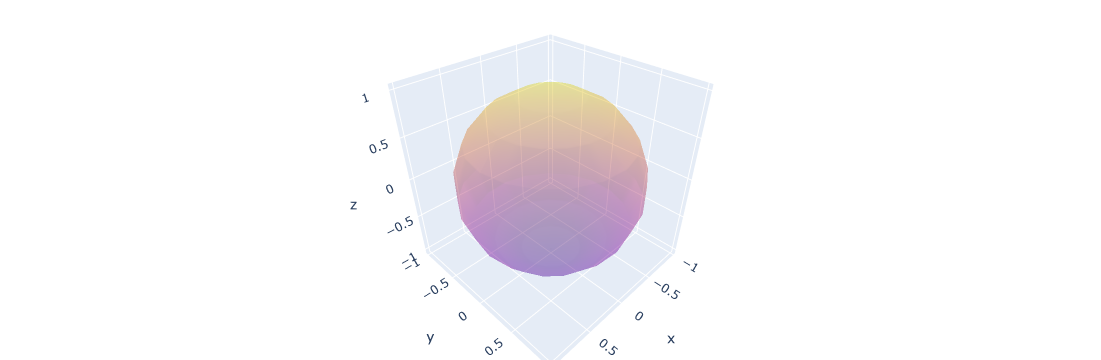

In [310]:

import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[],layout=layout)


fig.add_trace(go.Surface(x=X_surface, y=Y_surface, z=Z_surface, opacity=0.25, showlegend=False, showscale=False))

fig.show()

In [311]:
X_surfaceT, Y_surfaceT, Z_surfaceT = np.array_split(np.concatenate([
X_surface[:, :, np.newaxis],
Y_surface[:, :, np.newaxis],
Z_surface[:, :, np.newaxis]
], axis=-1).dot(T), 3, axis=-1)

X_surfaceT, Y_surfaceT, Z_surfaceT = X_surfaceT.squeeze(), Y_surfaceT.squeeze(), Z_surfaceT.squeeze()

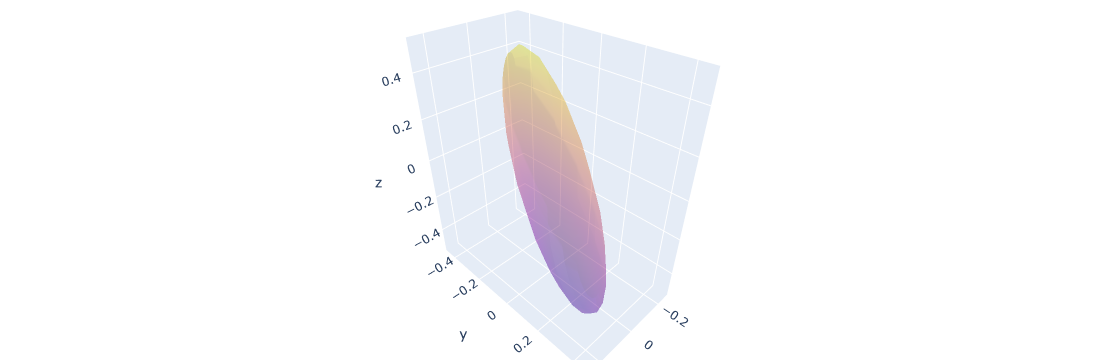

In [312]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=[],layout=layout)


fig.add_trace(go.Surface(x=X_surfaceT, y=Y_surfaceT, z=Z_surfaceT, opacity=0.25, showlegend=False, showscale=False))

fig.show()

In [291]:
T

array([[ 0.00550274,  0.12249448,  0.31726935],
       [-0.25705896, -0.37457836,  0.05657432],
       [ 0.0259998 , -0.21569169,  0.39150138]])